In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-04-24 14:31:06--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2023-04-24 14:31:06 (104 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [35]:
import json
with open("./sarcasm.json", "r") as f:
    datastore = json.load(f)
sentences, labels = [], []
for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [36]:
sentences[:3]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild"]

In [37]:
labels[:3]

[0, 0, 1]

In [38]:
training_size = 20000 #number of training samples
vocab_size = 15000 #vocabulary size
max_length = 32
embedding_dim = 64

In [39]:
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [40]:
print(f"""
Training sentences: {len(training_sentences)},
Testing sentences: {len(testing_sentences)},
Training labels: {len(training_labels)},
Testing labels: {len(testing_labels)}
""")


Training sentences: 20000,
Testing sentences: 6709,
Training labels: 20000,
Testing labels: 6709



In [41]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
trunct_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

In [43]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [44]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences, maxlen = max_length,
    padding = padding_type,
    truncating = trunct_type
)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences, maxlen = max_length,
    padding = padding_type,
    truncating = trunct_type
)

In [45]:
print(f"{type(training_padded)}\n{type(training_labels)}")

<class 'numpy.ndarray'>
<class 'list'>


In [46]:
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [47]:
print(f"{type(training_padded)}\n{type(training_labels)}")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### GlobalAveragePooling1D demonstration

In [48]:
import tensorflow as tf
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()
sample_array = np.array([[
    [3, 7, 9],
    [1, 5, 5],
    [2, 3, 4]
]])
print(f"Shape of sample array: {sample_array.shape}\n")
print(f"Sample array:\n {sample_array}")

Shape of sample array: (1, 3, 3)

Sample array:
 [[[3 7 9]
  [1 5 5]
  [2 3 4]]]


In [49]:
output = gap1d_layer(sample_array)

In [50]:
print(f"Output of the GAP1D layer:\n {output}\n")
print(f"Shape of the output: {output.shape}")

Output of the GAP1D layer:
 [[2 5 6]]

Shape of the output: (1, 3)


### Building and training the model

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 32, 64)            960000    
                                                                 
 global_average_pooling1d_8   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 961,585
Trainable params: 961,585
Non-trainable params: 0
________________________________________________

In [53]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [54]:
num_epochs = 30
callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor = "val_loss")
history = model.fit(
    training_padded, training_labels,
    epochs = num_epochs, validation_data = (testing_padded, testing_labels),
    verbose = 2, #setting it to 2 means it won't show progress bar just the progress
    callbacks = [callback]
)

Epoch 1/30
625/625 - 17s - loss: 0.5465 - accuracy: 0.7150 - val_loss: 0.3786 - val_accuracy: 0.8433 - 17s/epoch - 26ms/step
Epoch 2/30
625/625 - 4s - loss: 0.3105 - accuracy: 0.8781 - val_loss: 0.3354 - val_accuracy: 0.8584 - 4s/epoch - 6ms/step
Epoch 3/30
625/625 - 3s - loss: 0.2254 - accuracy: 0.9194 - val_loss: 0.3571 - val_accuracy: 0.8463 - 3s/epoch - 5ms/step
Epoch 4/30
625/625 - 3s - loss: 0.1686 - accuracy: 0.9456 - val_loss: 0.3888 - val_accuracy: 0.8489 - 3s/epoch - 4ms/step
Epoch 5/30
625/625 - 3s - loss: 0.1307 - accuracy: 0.9610 - val_loss: 0.4300 - val_accuracy: 0.8501 - 3s/epoch - 4ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1039 - accuracy: 0.9696 - val_loss: 0.4784 - val_accuracy: 0.8460 - 3s/epoch - 4ms/step
Epoch 7/30
625/625 - 3s - loss: 0.0835 - accuracy: 0.9774 - val_loss: 0.5428 - val_accuracy: 0.8416 - 3s/epoch - 4ms/step


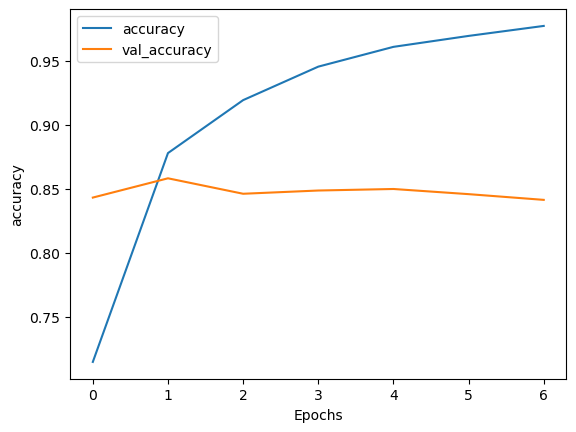

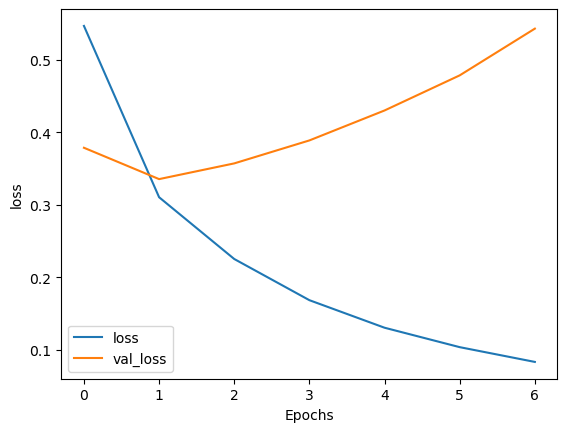

In [55]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [56]:
reverse_word_index = tokenizer.index_word
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape) 

(15000, 64)


In [57]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()